## Video loading and processing

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import time

In [ ]:
# use webcam
cap = cv2.VideoCapture(0)
W, H = 640, 480

In [2]:
# use video
video_path='E:/Data/video/pose_video_dataset/002_dance.mp4'
cap = cv2.VideoCapture(video_path)
# W, H = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
W, H = 640, 360

In [3]:
def cap_rewind(cap):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

def frame_generator(cap):
    while True:
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (W, H))
            yield frame
        else:
            break

def get_diff_mask(frame, prev_frame, threshold=0.1):
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    prev_grey = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    mask = cv2.absdiff(grey, prev_grey)
    _, thresh = cv2.threshold(mask, 255 * threshold, 255, cv2.THRESH_BINARY)
    return thresh

def get_bounding_box(mask, threshold=0.1):
    _, thresh = cv2.threshold(mask, 255 * threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    # pick the largest contour
    # cnt = max(contours, key=cv2.contourArea)
    # x, y, w, h = cv2.boundingRect(cnt)
    # get the bounding rect of all contours
    x, y, w, h = cv2.boundingRect(np.concatenate(contours))
    return x, y, w, h

## Prepare model


### normal model

In [4]:
# inshape = (3, 640, 480)

model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.AdaptiveAvgPool2d((32, 32)),
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 10)
)


### delta model for bounding box

The bounding box contains the delta of the values instead of the orinal values.

In [5]:
import copy

dmodel = copy.deepcopy(model)
for i, lyr in enumerate(dmodel):
    if isinstance(lyr, nn.Conv2d):
        lyr.bias = None
        pad = lyr.padding
        if isinstance(pad, int):
            pad = (pad, pad)
        lyr.padding = (max(pad[0], lyr.kernel_size[0] - 1), max(pad[1], lyr.kernel_size[1] - 1))
    elif isinstance(lyr, nn.Linear):
        lyr.bias = None
        

## Prepare functions

In [6]:
# import torchvision

def frame2tensor(frame):
    frame = frame.transpose((2, 0, 1))
    frame = torch.from_numpy(frame)
    frame = frame.float()
    frame = frame / 255
    return frame


def get_frame_in_box(frame:np.ndarray, x, y, w, h):
    return frame[y:y+h, x:x+w, :]

def get_tensor_in_box(data:torch.Tensor, x, y, w, h):
    return data[..., y:y+h, x:x+w]


### delta processing functions

In [7]:
def map_conv_incoord_to_outcoord(conv, x, y):
    x, y = x + conv.padding[0], y + conv.padding[1]
    x, y = x // conv.stride[0], y // conv.stride[1]
    return x, y

def map_conv_delta_incoord_to_outcoord(conv, x, y):
    x, y = x + conv.padding[0], y + conv.padding[1]
    x, y = x // conv.stride[0], y // conv.stride[1]
    x, y = x - conv.kernel_size[0] + 1, y - conv.kernel_size[1] + 1
    return x, y

def map_adaptive_pool_incoord_to_outcoord(pool, w, h, x, y):
    x, y = x // (w / pool.output_size[0]), y // (h / pool.output_size[1])
    x, y = int(x), int(y)
    return x, y

def map_pool_incoord_to_outcoord(pool, x, y):
    x, y = x + pool.padding[0] // pool.stride[0], y + pool.padding[1] // pool.stride[1]
    return x, y

def delta_conv(conv, delta, coord, old_result):
    x, y = coord
    x, y = map_conv_incoord_to_outcoord(conv, x, y)
    delta_res = conv(delta)
    _, _, h, w = delta_res.shape
    result = old_result[..., y:y+h, x:x+w].clone()
    result += delta_res
    return result

def delta_relu(layer, delta, coord, old_result):
    delta_res = layer(delta)
    x, y, w, h = coord
    result = old_result.clone()
    result[:, :, y:y+h, x:x+w] = delta_res
    return result

### ploting functions

In [8]:
def draw_bb(bb, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.add_patch(plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], fill=False, color='red'))


def draw_cb(symmetry=True):
    # ax = plt.gca() if ax is None else ax
    # fig = plt.gcf()
    cb_frac=0.047
    h = plt.ylim()
    h = abs(h[1]-h[0])
    w = plt.xlim()
    w = abs(w[1]-w[0])
    plt.colorbar(fraction=cb_frac*h/w)
    # if symmetry:
    #     c = plt.clim()
    #     print(c)
    #     m = max(abs(c[0]), abs(c[1]))
    #     plt.clim(-m, m)

## Processing

### normal processing

In [7]:
# frame = next(frame_generator(cap))
# prev_frame = frame

while True:
    frame = next(frame_generator(cap))
    #mask = get_diff_mask(frame, prev_frame)
    #bb = get_bounding_box(mask)
    if frame is None:
        break
    t = time.time()
    res = model(frame2tensor(frame).unsqueeze(0))
    d = torch.argmax(res).item()
    t = time.time() - t
    text = f'time={t*1000:.0f}ms, d={d}'
    cv2.putText(frame, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

### delta processing (one layer)

In [28]:
# small resolution for debugging
W, H = 64, 36

In [9]:
frame = next(frame_generator(cap))
prev_frame = frame
# prev_result = model(frame2tensor(frame).unsqueeze(0))

d = frame2tensor(prev_frame).unsqueeze(0)
buffer = model[0](d)

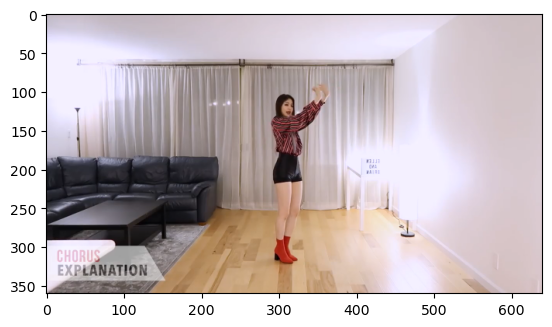

In [10]:
plt.imshow(prev_frame[:,:,::-1])

In [11]:
frame = next(frame_generator(cap))
print(frame.shape)

mask = get_diff_mask(frame, prev_frame, 0.05)
print((mask!=0).sum())

bb = get_bounding_box(mask)
print(bb)

if bb is None:
    print(f"Frames are the same (at threshold {0.05}). Try get a new frame, or lower the threshold.")
else:
    x1 = frame2tensor(prev_frame).unsqueeze(0)
    x2 = frame2tensor(frame).unsqueeze(0)
    delta = get_tensor_in_box(x2-x1, *bb)
    # xd = get_frame_in_box(frame - prev_frame, *bb) # this is wrong because frame is uint8, its minus is modulo
    print(delta.shape)

(360, 640, 3)
410
(298, 91, 67, 97)
torch.Size([1, 3, 97, 67])


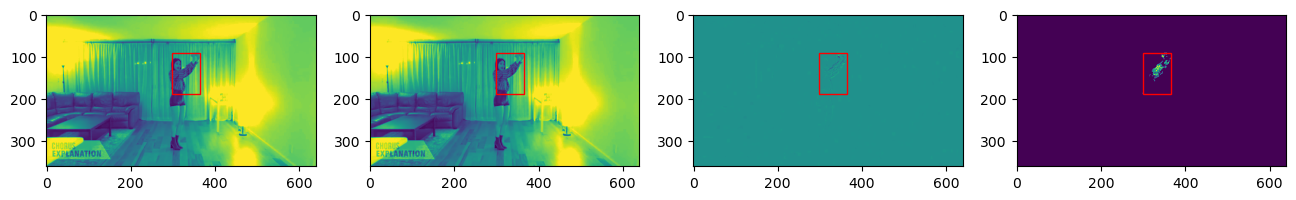

In [12]:
plt.subplots(1,4, figsize=(16,4));
plt.subplot(1,4,1); plt.imshow(x1[0,0].numpy()); draw_bb(bb)
plt.subplot(1,4,2); plt.imshow(x2[0,0].numpy()); draw_bb(bb)
plt.subplot(1,4,3); plt.imshow(x2[0,0]-x1[0,0].numpy()); draw_bb(bb)
plt.subplot(1,4,4); plt.imshow(mask); draw_bb(bb)

In [13]:
with torch.no_grad():
    o_full = model[0](frame2tensor(frame).unsqueeze(0))
    o_delta = dmodel[0](delta)

In [14]:
ox, oy = map_conv_delta_incoord_to_outcoord(model[0], bb[0], bb[1])
oh, ow = o_delta.shape[2], o_delta.shape[3]

print(o_delta.shape)
print(*bb)
print(ox, oy, ow, oh)
# print(o_delta)

o_merge = buffer.clone()
o_merge[..., oy:oy+oh, ox:ox+ow] += o_delta

torch.Size([1, 16, 99, 69])
298 91 67 97
297 90 69 99


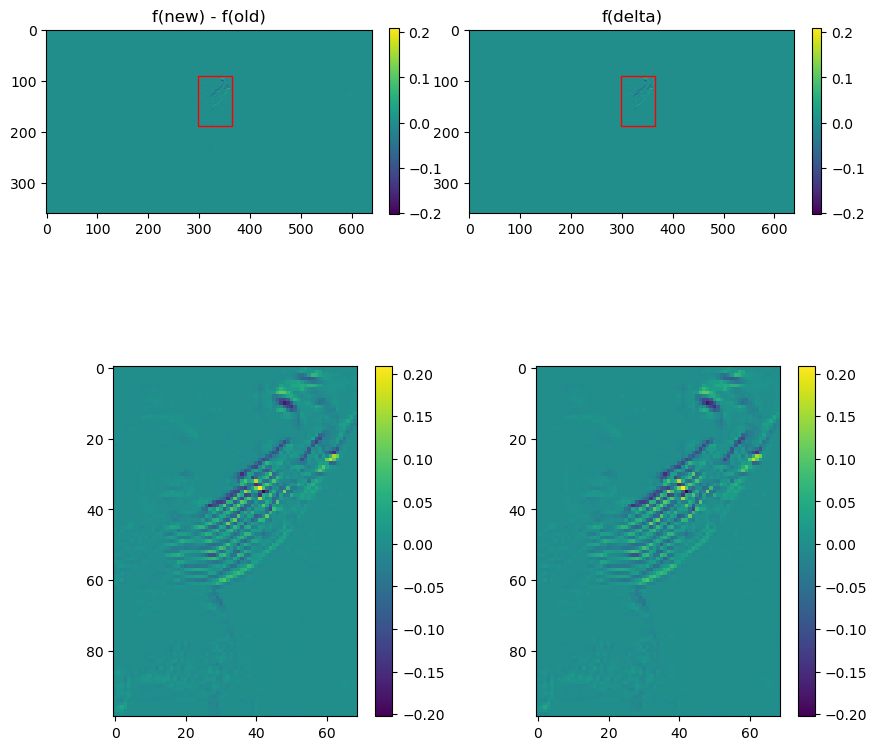

In [16]:
# print(o_full[0,0,oy:oy+oh,ox:ox+ow])
with torch.no_grad():
    dy = o_full - buffer
pad_delta = torch.zeros_like(buffer)
pad_delta[..., oy:oy+oh, ox:ox+ow] = o_delta
# print(dy[0,0,oy-1:oy+oh+1,ox-1:ox+ow+1])
# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(dy[0,0].numpy()); draw_bb(bb); draw_cb(); plt.title('f(new) - f(old)')
plt.subplot(2,2,2)
plt.imshow(pad_delta[0,0].numpy()); draw_bb(bb); draw_cb(); plt.title('f(delta)')
# print(o_delta[0,0])
plt.subplot(2,2,3)
plt.imshow(dy[0,0,oy:oy+oh,ox:ox+ow].numpy()); draw_cb()
plt.subplot(2,2,4)
plt.imshow(o_delta[0,0].numpy()); draw_cb()

In [18]:
@torch.no_grad()
def rmse(a, b):
    return torch.sqrt(torch.mean((a-b)**2))

@torch.no_grad()
def rrmse(a, b):
    return torch.sqrt(torch.mean((a-b)**2)/torch.sum(a**2))

print("Total difference (RRMSE):", rrmse(o_full, o_merge))

print("Difference in delta range (RRMSE)", rrmse(o_full[..., oy:oy+oh, ox:ox+ow], o_merge[..., oy:oy+oh, ox:ox+ow]))

diff = o_full[0] - o_merge[0]
print(diff.max(), diff.min())

Total difference (RRMSE): tensor(8.2396e-07)
Difference in delta range (RRMSE) tensor(5.0625e-06)
tensor(0.0284, grad_fn=<MaxBackward1>) tensor(-0.0321, grad_fn=<MinBackward1>)


### delta processing (network)

In [19]:
frame = next(frame_generator(cap))
prev_frame = frame

d = frame2tensor(prev_frame).unsqueeze(0)
prev_buffer = [d]
with torch.no_grad():
    for i, lyr in enumerate(model):
        d = lyr(d)
        prev_buffer.append(d)

In [20]:
frame = next(frame_generator(cap))
print(frame.shape)

mask = get_diff_mask(frame, prev_frame, 0.05)
print((mask!=0).sum())

bb = get_bounding_box(mask)
print(bb)

if bb is None:
    print(f"Frames are the same (at threshold {0.05}). Try get a new frame, or lower the threshold.")
else:
    x1 = frame2tensor(prev_frame).unsqueeze(0)
    x2 = frame2tensor(frame).unsqueeze(0)
    delta = get_tensor_in_box(x2-x1, *bb)
    # xd = get_frame_in_box(frame - prev_frame, *bb) # this is wrong because frame is uint8, its minus is modulo
    print(delta.shape)

(360, 640, 3)
716
(310, 91, 55, 88)
torch.Size([1, 3, 88, 55])


0 torch.Size([1, 3, 360, 640])
1 torch.Size([1, 16, 360, 640])
2 torch.Size([1, 16, 360, 640])
3 torch.Size([1, 32, 360, 640])
4 torch.Size([1, 32, 360, 640])
5 torch.Size([1, 32, 32, 32])
6 torch.Size([1, 32768])
7 torch.Size([1, 10])
0 Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (310, 91, 55, 88) -> (309, 90, 57, 90), torch.Size([1, 16, 90, 57])
1 ReLU()
2 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (309, 90, 57, 90) -> (308, 89, 59, 92), torch.Size([1, 32, 92, 59])
3 ReLU()
4 AdaptiveAvgPool2d(output_size=(32, 32))
  (308, 89, 59, 92) -> (15, 7, 3, 9), torch.Size([1, 32, 9, 3])
5 Flatten(start_dim=1, end_dim=-1)
  torch.Size([1, 32, 32, 32]), (15, 7, 3, 9), torch.Size([1, 32, 9, 3]), torch.Size([1, 32, 9, 3])
6 Linear(in_features=32768, out_features=10, bias=False)


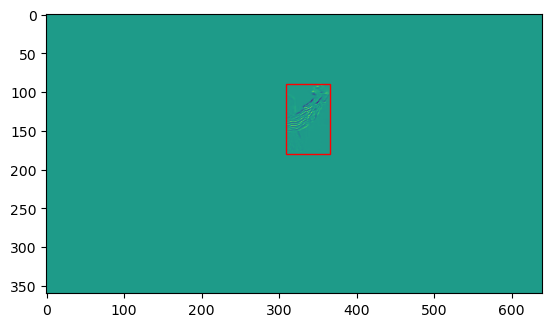

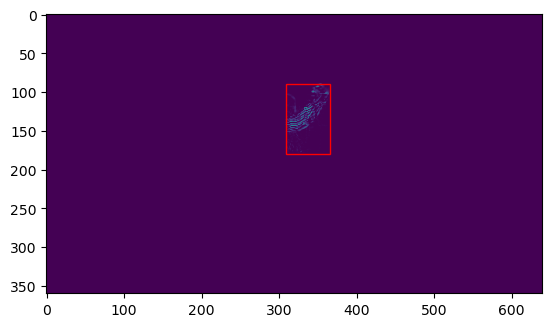

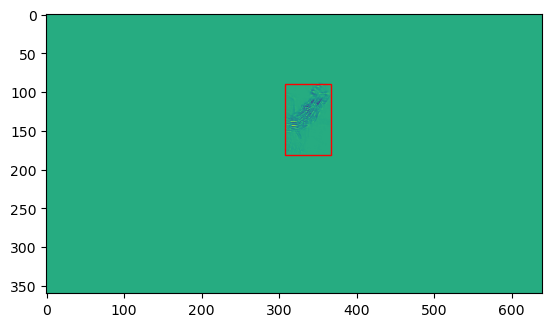

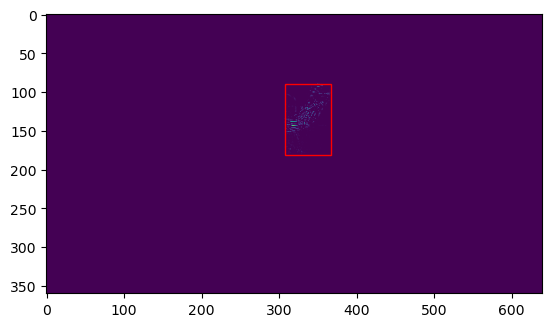

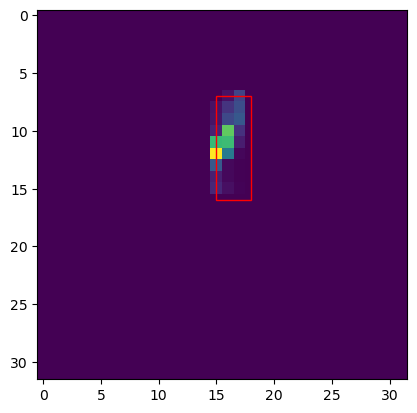

In [21]:
d = delta
b = bb
buffer = [d]
bb_list = [b]
for i in range(len(prev_buffer)):
    print(i, prev_buffer[i].shape)
with torch.no_grad():
    for i, lyr in enumerate(dmodel):
        print(i, lyr)
        if isinstance(lyr, nn.Conv2d):
            d = lyr(d)
            ox, oy = map_conv_delta_incoord_to_outcoord(model[i], b[0], b[1])
            oh, ow = d.shape[2], d.shape[3]
            print(f'  {b} -> {(ox, oy, ow, oh)}, {d.shape}')
            # cut off those out of box
            original_height, original_width = prev_buffer[i].shape[2:]
            cut_x_0 = -ox if ox < 0 else 0
            cut_y_0 = -oy if oy < 0 else 0
            cut_x_1 = ox + ow - original_width if ox + ow > original_width else 0
            cut_y_1 = oy + oh - original_height if oy + oh > original_height else 0
            if cut_x_0 != 0 or cut_y_0 != 0 or cut_x_1 != 0 or cut_y_1 != 0:
                d = d[..., cut_y_0:oh-cut_y_0-cut_y_1, cut_x_0:ow-cut_x_0-cut_x_1]
                print(f'  cut to {d.shape}')
            b = (ox, oy, ow, oh)
        elif isinstance(lyr, nn.ReLU):
            d = lyr(d)
        elif isinstance(lyr, nn.MaxPool2d):
            # padding: first int is used for the height dimension, and the second int for the width dimension
            x0_q, x0_r = divmod(b[0] + lyr.padding[0], lyr.stride[0])
            y0_q, y0_r = divmod(b[1] + lyr.padding[1], lyr.stride[1])
            x1_q, x1_r = divmod(b[0] + b[2] + lyr.padding[0], lyr.stride[0])
            y1_q, y1_r = divmod(b[1] + b[3] + lyr.padding[1], lyr.stride[1])
            if x0_r != 0 or y0_r != 0:
                lyr.padding = (lyr.padding[0], lyr.padding[1])
            lyr.ceil_mode = True
            d = lyr(d)
            # ox, oy = map_pool_incoord_to_outcoord(model[i], b[0], b[1])
            ox, oy = x0_q, y0_q
            oh, ow = d.shape[2], d.shape[3]
            print(f'  {b} -> {(ox, oy, ow, oh)}, {d.shape}')
        elif isinstance(lyr, nn.AdaptiveAvgPool2d):
            h, w = prev_buffer[i].shape[2], prev_buffer[i].shape[3]
            ox, oy = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0], b[1])
            ox2, oy2 = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0]+b[2], b[1]+b[3])
            ow, oh = ox2-ox, oy2-oy
            lyr = nn.AdaptiveAvgPool2d((oh, ow))
            d = lyr(d)
            print(f'  {b} -> {(ox, oy, ow, oh)}, {d.shape}')
            b = (ox, oy, ow, oh)
        elif isinstance(lyr, nn.Flatten):
            ox, oy, ow, oh = b
            print(f'  {prev_buffer[i].shape}, {b}, {d.shape}, {prev_buffer[i][..., oy:oy+oh, ox:ox+ow].shape}')
            # tmp = prev_buffer[i].clone()
            # tmp[..., oy:oy+oh, ox:ox+ow] += d
            tmp = torch.zeros_like(prev_buffer[i])
            tmp[..., oy:oy+oh, ox:ox+ow] = d
            d = lyr(tmp)
            b = None
        elif isinstance(lyr, nn.Linear):
            d = lyr(d)
            b = None
        buffer.append(d)
        bb_list.append(b)
        if isinstance(lyr, (nn.Flatten, nn.Linear)):
            continue
        plt.figure()
        ox, oy, ow, oh = b
        tmp_pad = torch.zeros_like(prev_buffer[i+1])
        tmp_pad[..., oy:oy+oh, ox:ox+ow] = d
        plt.imshow(tmp_pad[0,0].detach().numpy()); draw_bb(b);

In [23]:
# accuracy
with torch.no_grad():
    o_full = model(frame2tensor(frame).unsqueeze(0))
print(o_full - prev_buffer[-1])
print(buffer[-1])
print(o_full - (prev_buffer[-1] + buffer[-1]))

tensor([[-2.1174e-04, -2.8098e-04, -1.9306e-04, -4.8086e-05,  5.7831e-05,
         -8.4303e-06, -1.7146e-04,  1.2059e-05, -1.5945e-04, -2.0612e-04]])
tensor([[ 8.6087e-05,  5.9189e-04, -6.7077e-05,  2.4114e-04, -1.0834e-03,
         -4.1328e-04, -4.1465e-04,  6.2705e-04, -1.2458e-03,  6.8853e-05]])
tensor([[-0.0003, -0.0009, -0.0001, -0.0003,  0.0011,  0.0004,  0.0002, -0.0006,
          0.0011, -0.0003]])


In [24]:
# efficiency
for i in range(len(prev_buffer)):
    n_cmp = prev_buffer[i].numel()
    n_delta = buffer[i].numel()
    print(i, n_cmp, n_delta, n_delta/n_cmp)

0 691200 14520 0.021006944444444446
1 3686400 82080 0.022265625
2 3686400 82080 0.022265625
3 7372800 173696 0.02355902777777778
4 7372800 173696 0.02355902777777778
5 32768 864 0.0263671875
6 32768 32768 1.0
7 10 10 1.0


In [27]:
# normal processing
t = time.time()
x = frame2tensor(frame).unsqueeze(0)
_ = model(x)
t = time.time() - t
print(t)

# delta processing
t = time.time()
d = delta
b = bb
with torch.no_grad():
    for i, lyr in enumerate(dmodel):
        if isinstance(lyr, nn.Conv2d):
            d = lyr(d)
            ox, oy = map_conv_delta_incoord_to_outcoord(model[i], b[0], b[1])
            oh, ow = d.shape[2], d.shape[3]
            b = (ox, oy, ow, oh)
        elif isinstance(lyr, nn.ReLU):
            d = lyr(d)
        elif isinstance(lyr, nn.AdaptiveAvgPool2d):
            h, w = prev_buffer[i].shape[2], prev_buffer[i].shape[3]
            ox, oy = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0], b[1])
            ox2, oy2 = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0]+b[2], b[1]+b[3])
            ow, oh = ox2-ox, oy2-oy
            lyr = nn.AdaptiveAvgPool2d((oh, ow))
            d = lyr(d)
            b = (ox, oy, ow, oh)
        elif isinstance(lyr, nn.Flatten):
            ox, oy, ow, oh = b
            tmp = prev_buffer[i].clone()
            tmp[..., oy:oy+oh, ox:ox+ow] += d
            d = lyr(tmp)
            b = None
        elif isinstance(lyr, nn.Linear):
            d = lyr(d)
            b = None
        # buffer.append(d)
        # bb_list.append(b)
t = time.time() - t
print(t)

0.07830429077148438
0.0020029544830322266


### delta processing (complete)

In [ ]:
# frame = next(frame_generator(cap))
# prev_frame = frame

# d = frame2tensor(prev_frame).unsqueeze(0)
# prev_buffer = [d]
# for i, lyr in enumerate(model):
#     d = lyr(d)
#     prev_buffer.append(d)

while True:
    frame = next(frame_generator(cap))
    if frame is None:
        break
    mask = get_diff_mask(frame, prev_frame)
    bb = get_bounding_box(mask)
    if bb is None:
        continue
    t = time.time()
    x = frame2tensor(frame).unsqueeze(0)
    d = x - prev_buffer[0]
    b = bb
    buffer = [x]
    bb_list = [bb]
    with torch.no_grad():
        for i, lyr in enumerate(dmodel):
            if isinstance(lyr, nn.Conv2d):
                d = lyr(d)
                ox, oy = map_conv_delta_incoord_to_outcoord(model[i], b[0], b[1])
                oh, ow = d.shape[2], d.shape[3]
                b = (ox, oy, ow, oh)
            elif isinstance(lyr, nn.ReLU):
                d = lyr(d)
            elif isinstance(lyr, nn.AdaptiveAvgPool2d):
                h, w = prev_buffer[i].shape[2], prev_buffer[i].shape[3]
                ox, oy = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0], b[1])
                ox2, oy2 = map_adaptive_pool_incoord_to_outcoord(model[i], w, h, b[0]+b[2], b[1]+b[3])
                ow, oh = ox2-ox, oy2-oy
                lyr = nn.AdaptiveAvgPool2d((oh, ow))
                d = lyr(d)
                b = (ox, oy, ow, oh)
            elif isinstance(lyr, nn.Flatten):
                ox, oy, ow, oh = b
                tmp = prev_buffer[i].clone()
                tmp[..., oy:oy+oh, ox:ox+ow] += d
                d = lyr(tmp)
                b = None
            elif isinstance(lyr, nn.Linear):
                xd = lyr(xd)
            buffer.append(xd)
        d = buffer[-1][0].argmax().item()
    t = time.time() - t
    cv2.imshow('frame', frame)
    text = f'time={t*1000:.0f}ms, d={d}'
    cv2.text(frame, text, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    if cv2.waitKey(1) == ord('q'):
        break